In [135]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import torch

from matplotlib import pyplot as plt
import seaborn as sns

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical 

from transformers import BertTokenizer, BertModel

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import json

from sklearn.metrics import f1_score, accuracy_score
from keras.callbacks import Callback
import numpy as np
import pickle

In [136]:
train_data = json.load(open('../Dataset/BIO_Tagged/ATE_train.json'))
val_data = json.load(open('../Dataset/BIO_Tagged/ATE_val.json'))
test_data = json.load(open('../Dataset/BIO_Tagged/ATE_test.json'))

In [137]:
word2vec = pickle.load(open('Word Embeddings/word2vec.pkl', 'rb'))
glove = pickle.load(open('Word Embeddings/glove.pkl', 'rb'))
bert = pickle.load(open('Word Embeddings/bert.pkl', 'rb'))

In [138]:
# word_to_idx = {}

# for case in train_data:
#     for text in train_data[case]['text'].split(' '):
#         if text not in word_to_idx:
#             word_to_idx[text] = len(word_to_idx)

# for case in test_data:
#     for text in test_data[case]['text'].split(' '):
#         if text not in word_to_idx:
#             word_to_idx[text] = len(word_to_idx)

# for case in val_data:
#     for text in val_data[case]['text'].split(' '):
#         if text not in word_to_idx:
#             word_to_idx[text] = len(word_to_idx)

In [139]:
# tag_to_ix = {}

# for case in train_data:
#     for tag in train_data[case]['labels']:
#         if tag not in tag_to_ix:
#             tag_to_ix[tag] = len(tag_to_ix)

# for case in test_data:
#     for tag in test_data[case]['labels']:
#         if tag not in tag_to_ix:
#             tag_to_ix[tag] = len(tag_to_ix)

# for case in val_data:
#     for tag in val_data[case]['labels']:
#         if tag not in tag_to_ix:
#             tag_to_ix[tag] = len(tag_to_ix)

# tag_to_ix['START_TAG'] = len(tag_to_ix)
# tag_to_ix['END_TAG'] = len(tag_to_ix)

In [140]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained("bert-base-uncased")

In [141]:
# embedding_mat = np.zeros((len(word_to_idx), 768))

# for word, idx in tqdm(word_to_idx.items()):
#     try:
#         tokens = tokenizer.batch_encode_plus([word], return_tensors='pt', add_special_tokens=False)
#     except:
#         tokens = tokenizer.batch_encode_plus(['unk'], return_tensors='pt', add_special_tokens=False)
#         continue
#     embeddings = None
#     with torch.no_grad():
#         try:
#             outputs = model(**tokens)
#             embeddings = outputs.last_hidden_state
#         except:
#             tokens = tokenizer.batch_encode_plus(['unk'], return_tensors='pt', add_special_tokens=False)
#             outputs = model(**tokens)
#             embeddings = outputs.last_hidden_state
#     embeddings = embeddings.squeeze(0)
#     word_embeddings = embeddings.mean(dim = 0)
#     embedding_mat[idx] = word_embeddings.squeeze(0).numpy()

In [142]:
# pickle.dump(embedding_mat, open('Word Embeddings/bert.pkl', 'wb'))

In [143]:
# def create_embedding_matrix(model, word_index, embedding_dim):
#     embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
#     for word, i in word_index.items():
#         if word in model.wv:
#             embedding_matrix[i] = model.wv[word]
#         # Else, you can choose to initialize randomly or use a special token here
#     return embedding_matrix

In [187]:
def prepareData(train_data, val_data, test_data, embedding_type):
    # Combine all datasets for consistent tokenization and vocabulary creation
    all_data = {**train_data, **val_data, **test_data}
        
    # Extract texts and labels from the combined data
    texts = [item["text"] for item in all_data.values()]
    labels = [item["labels"] for item in all_data.values()]
    
    word_tokenizer = Tokenizer()                      
    word_tokenizer.fit_on_texts(texts)                    
    
    train_sequences = word_tokenizer.texts_to_sequences([item["text"] for item in train_data.values()])
    val_sequences = word_tokenizer.texts_to_sequences([item["text"] for item in val_data.values()])
    test_sequences = word_tokenizer.texts_to_sequences([item["text"] for item in test_data.values()])
 
    max_sequence_length = 50 
    vocab_size = len(word_tokenizer.word_index) + 1  # Adding 1 for the zero-padding

    X_train = pad_sequences(train_sequences, maxlen=max_sequence_length)
    X_val = pad_sequences(val_sequences, maxlen=max_sequence_length)
    X_test = pad_sequences(test_sequences, maxlen=max_sequence_length)


    tag_tokenizer = Tokenizer()
    tag_tokenizer.fit_on_texts(labels)

    train_labels = tag_tokenizer.texts_to_sequences([item["labels"] for item in train_data.values()])
    val_labels = tag_tokenizer.texts_to_sequences([item["labels"] for item in val_data.values()])
    test_labels = tag_tokenizer.texts_to_sequences([item["labels"] for item in test_data.values()])

    max_label_length = 50    
    num_classes = len(tag_tokenizer.word_index) + 1  # Adding 1 for the zero-padding

    Y_train = pad_sequences(train_labels, maxlen=max_label_length)
    Y_val = pad_sequences(val_labels, maxlen=max_label_length)
    Y_test = pad_sequences(test_labels, maxlen=max_label_length)    

    try:
        embedding_dim = embedding_type.vector_size
    except AttributeError:
        embedding_dim = 768

    embedding_matrix = np.zeros((len(word_tokenizer.word_index) + 1, embedding_dim))
    word2id = word_tokenizer.word_index

    for word, index in word2id.items():
        try:
            embedding_matrix[index, :] = embedding_type[word]
        except IndexError:
            embedding_matrix[index, :] = embedding_type[index]
        except KeyError:
            pass       

    Y_train = to_categorical(Y_train)
    Y_val = to_categorical(Y_val)
    Y_test = to_categorical(Y_test)    

    return X_train, X_val, X_test, Y_train, Y_val, Y_test, vocab_size, embedding_dim, max_sequence_length, num_classes, embedding_matrix, word_tokenizer, tag_tokenizer

In [188]:
data = {}
data['word2vec'] = {}
data['glove'] = {}
data['bert'] = {}

data['word2vec']['X_train'], data['word2vec']['X_val'], data['word2vec']['X_test'], data['word2vec']['Y_train'], data['word2vec']['Y_val'], data['word2vec']['Y_test'], data['word2vec']['vocab_size'], data['word2vec']['embedding_dim'], data['word2vec']['max_sequence_length'], data['word2vec']['num_classes'], data['word2vec']['embedding_matrix'], word_tokenizer, tag_tokenizer = prepareData(train_data, val_data, test_data, word2vec)
data['glove']['X_train'], data['glove']['X_val'], data['glove']['X_test'], data['glove']['Y_train'], data['glove']['Y_val'], data['glove']['Y_test'], data['glove']['vocab_size'], data['glove']['embedding_dim'], data['glove']['max_sequence_length'], data['glove']['num_classes'], data['glove']['embedding_matrix'], word_tokenizer, tag_tokenizer = prepareData(train_data, val_data, test_data, glove)
data['bert']['X_train'], data['bert']['X_val'], data['bert']['X_test'], data['bert']['Y_train'], data['bert']['Y_val'], data['bert']['Y_test'], data['bert']['vocab_size'], data['bert']['embedding_dim'], data['bert']['max_sequence_length'], data['bert']['num_classes'], data['bert']['embedding_matrix'], word_tokenizer, tag_tokenizer = prepareData(train_data, val_data, test_data, bert)

In [189]:
class MacroF1ScoreCallback(Callback):
    def __init__(self, train_data, val_data):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.train_f1s = []
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        train_pred = np.argmax(self.model.predict(self.train_data[0]), axis=-1)
        train_true = np.argmax(self.train_data[1], axis=-1)
        train_f1 = f1_score(train_true.flatten(), train_pred.flatten(), average='macro')

        val_pred = np.argmax(self.model.predict(self.val_data[0]), axis=-1)
        val_true = np.argmax(self.val_data[1], axis=-1)
        val_f1 = f1_score(val_true.flatten(), val_pred.flatten(), average='macro')

        self.train_f1s.append(train_f1)
        self.val_f1s.append(val_f1)
        print(f'Epoch {epoch + 1} - Train Macro-F1: {train_f1:.4f} - Val Macro-F1: {val_f1:.4f}')


## VANILLA RNN

In [196]:
def trainRNN(embedding):
    X_train, Y_train, X_val, Y_val, embedding_matrix = data[embedding]['X_train'], data[embedding]['Y_train'], data[embedding]['X_val'], data[embedding]['Y_val'], data[embedding]['embedding_matrix']
    
    NUM_CLASSES = data[embedding]['num_classes']
    VOCABULARY_SIZE = data[embedding]['vocab_size']
    EMBEDDING_SIZE = data[embedding]['embedding_dim']
    MAX_SEQUENCE_LENGTH = data[embedding]['max_sequence_length']

    rnn_model = Sequential()
    rnn_model.add(Embedding(input_dim=VOCABULARY_SIZE,
                            output_dim=EMBEDDING_SIZE,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix],
                            trainable=True))

    rnn_model.add(SimpleRNN(64, return_sequences=True))

    rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    rnn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    macro_f1_callback = MacroF1ScoreCallback(train_data=(X_train, Y_train), val_data=(X_val, Y_val))

    macro_f1_scores = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=50, validation_data=(X_val, Y_val), callbacks=[macro_f1_callback])

    rnn_model.save(f'Models/t2_rnn_{embedding}.h5')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title(f'Loss - {embedding} RNN')
    plt.plot(macro_f1_scores.history['loss'], label='Training Loss')
    plt.plot(macro_f1_scores.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f'Macro F1 - {embedding} RNN')
    plt.plot(macro_f1_callback.train_f1s, label='Training Macro-F1')
    plt.plot(macro_f1_callback.val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epochs')
    plt.ylabel('Macro-F1 Score')
    plt.legend()

    plt.show()


Epoch 1/50
7/7 [==============================] - 0s 2ms/step
Epoch 1 - Train Macro-F1: 0.4392 - Val Macro-F1: 0.4327
8/8 [==============================] - 1s 54ms/step - loss: 1.1604 - acc: 0.8187 - val_loss: 0.7841 - val_acc: 0.8602
Epoch 2/50
7/7 [==============================] - 0s 2ms/step
Epoch 2 - Train Macro-F1: 0.4393 - Val Macro-F1: 0.4322
8/8 [==============================] - 0s 39ms/step - loss: 0.6418 - acc: 0.8627 - val_loss: 0.5453 - val_acc: 0.8595
Epoch 3/50
7/7 [==============================] - 0s 2ms/step
Epoch 3 - Train Macro-F1: 0.4479 - Val Macro-F1: 0.4409
8/8 [==============================] - 0s 40ms/step - loss: 0.4843 - acc: 0.8766 - val_loss: 0.4573 - val_acc: 0.8739
Epoch 4/50
7/7 [==============================] - 0s 2ms/step
Epoch 4 - Train Macro-F1: 0.4458 - Val Macro-F1: 0.4392
8/8 [==============================] - 0s 38ms/step - loss: 0.4281 - acc: 0.8785 - val_loss: 0.4493 - val_acc: 0.8710
Epoch 5/50
7/7 [==============================] - 0s 2ms

/opt/homebrew/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


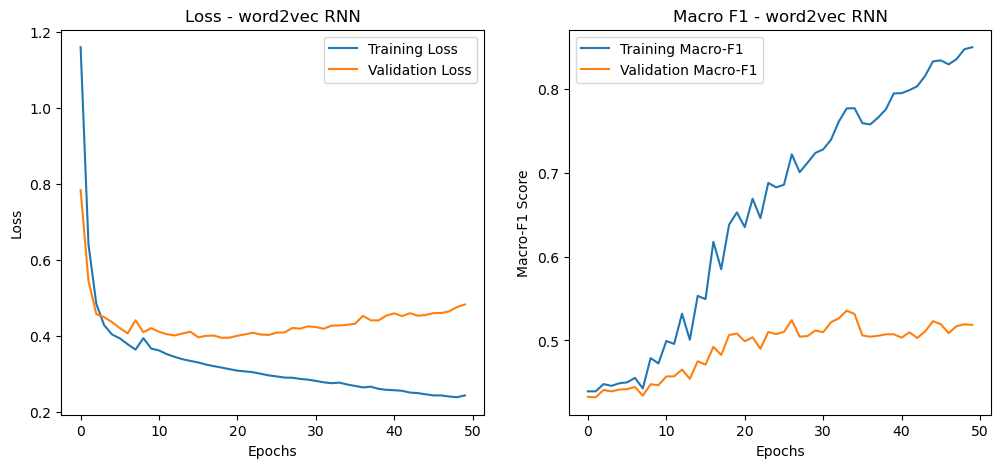

In [197]:
trainRNN('word2vec')

Epoch 1/50
7/7 [==============================] - 0s 2ms/step
Epoch 1 - Train Macro-F1: 0.4469 - Val Macro-F1: 0.4313
8/8 [==============================] - 1s 53ms/step - loss: 1.1234 - acc: 0.7675 - val_loss: 0.6561 - val_acc: 0.8521
Epoch 2/50
7/7 [==============================] - 0s 2ms/step
Epoch 2 - Train Macro-F1: 0.4496 - Val Macro-F1: 0.4380
8/8 [==============================] - 0s 36ms/step - loss: 0.5705 - acc: 0.8627 - val_loss: 0.5477 - val_acc: 0.8656
Epoch 3/50
7/7 [==============================] - 0s 2ms/step
Epoch 3 - Train Macro-F1: 0.4582 - Val Macro-F1: 0.4464
8/8 [==============================] - 0s 36ms/step - loss: 0.4781 - acc: 0.8780 - val_loss: 0.4757 - val_acc: 0.8748
Epoch 4/50
7/7 [==============================] - 0s 2ms/step
Epoch 4 - Train Macro-F1: 0.4547 - Val Macro-F1: 0.4442
8/8 [==============================] - 0s 37ms/step - loss: 0.4374 - acc: 0.8846 - val_loss: 0.4614 - val_acc: 0.8751
Epoch 5/50
7/7 [==============================] - 0s 2ms

/opt/homebrew/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


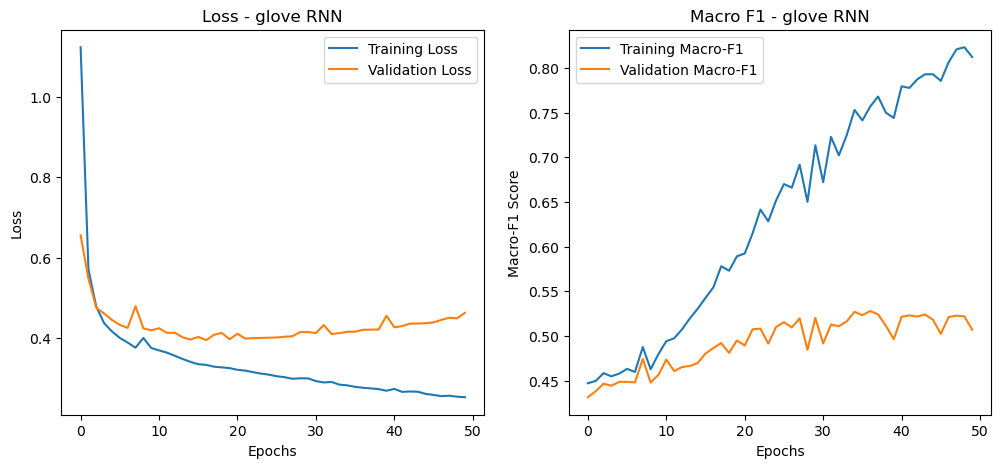

In [198]:
trainRNN('glove')

Epoch 1/50
7/7 [==============================] - 0s 4ms/step
Epoch 1 - Train Macro-F1: 0.4497 - Val Macro-F1: 0.4425
8/8 [==============================] - 1s 71ms/step - loss: 0.9633 - acc: 0.8554 - val_loss: 0.5751 - val_acc: 0.8763
Epoch 2/50
7/7 [==============================] - 0s 4ms/step
Epoch 2 - Train Macro-F1: 0.4705 - Val Macro-F1: 0.4691
8/8 [==============================] - 0s 58ms/step - loss: 0.5049 - acc: 0.8850 - val_loss: 0.5305 - val_acc: 0.8732
Epoch 3/50
7/7 [==============================] - 0s 4ms/step
Epoch 3 - Train Macro-F1: 0.4497 - Val Macro-F1: 0.4425
8/8 [==============================] - 0s 59ms/step - loss: 0.4558 - acc: 0.8850 - val_loss: 0.4747 - val_acc: 0.8763
Epoch 4/50
7/7 [==============================] - 0s 4ms/step
Epoch 4 - Train Macro-F1: 0.4519 - Val Macro-F1: 0.4425
8/8 [==============================] - 0s 58ms/step - loss: 0.4183 - acc: 0.8864 - val_loss: 0.4534 - val_acc: 0.8763
Epoch 5/50
7/7 [==============================] - 0s 4ms

/opt/homebrew/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


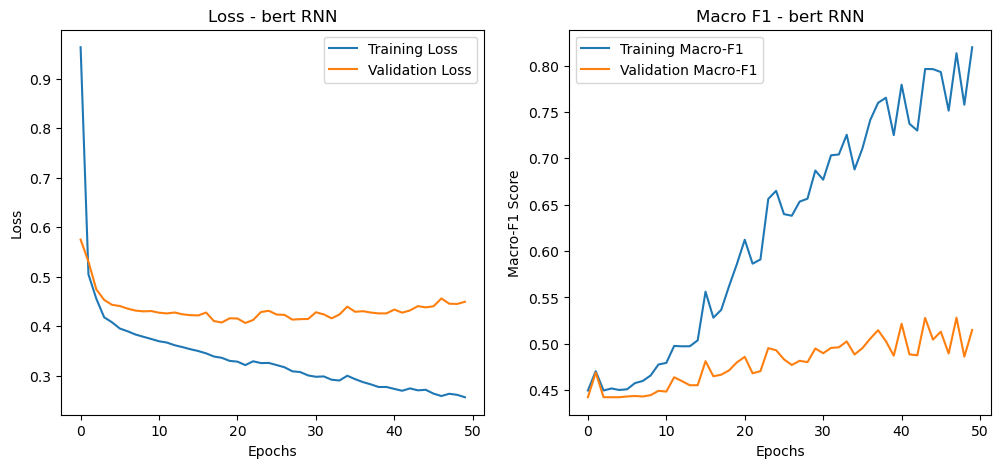

In [199]:
trainRNN('bert')

## LSTM

In [200]:
def trainLSTM(embedding):
    X_train, Y_train, X_val, Y_val, embedding_matrix = data[embedding]['X_train'], data[embedding]['Y_train'], data[embedding]['X_val'], data[embedding]['Y_val'], data[embedding]['embedding_matrix']
    
    NUM_CLASSES = data[embedding]['num_classes']
    VOCABULARY_SIZE = data[embedding]['vocab_size']
    EMBEDDING_SIZE = data[embedding]['embedding_dim']
    MAX_SEQUENCE_LENGTH = data[embedding]['max_sequence_length']

    lstm_model = Sequential()
    lstm_model.add(Embedding(input_dim=VOCABULARY_SIZE,
                            output_dim=EMBEDDING_SIZE,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix],
                            trainable=True))

    lstm_model.add(LSTM(64, return_sequences=True))

    lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    lstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    macro_f1_callback = MacroF1ScoreCallback(train_data=(X_train, Y_train), val_data=(X_val, Y_val))

    macro_f1_scores = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=50, validation_data=(X_val, Y_val), callbacks=[macro_f1_callback])

    lstm_model.save(f'Models/t2_lstm_{embedding}.h5')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title(f'Loss - {embedding} LSTM')
    plt.plot(macro_f1_scores.history['loss'], label='Training Loss')
    plt.plot(macro_f1_scores.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f'Macro F1 - {embedding} LSTM')
    plt.plot(macro_f1_callback.train_f1s, label='Training Macro-F1')
    plt.plot(macro_f1_callback.val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epochs')
    plt.ylabel('Macro-F1 Score')
    plt.legend()

    plt.show()


Epoch 1/50
7/7 [==============================] - 0s 5ms/step
Epoch 1 - Train Macro-F1: 0.4433 - Val Macro-F1: 0.4368
8/8 [==============================] - 1s 108ms/step - loss: 1.3037 - acc: 0.8151 - val_loss: 1.1220 - val_acc: 0.8668
Epoch 2/50
7/7 [==============================] - 0s 6ms/step
Epoch 2 - Train Macro-F1: 0.4205 - Val Macro-F1: 0.4117
8/8 [==============================] - 1s 75ms/step - loss: 0.9591 - acc: 0.8674 - val_loss: 0.7454 - val_acc: 0.8283
Epoch 3/50
7/7 [==============================] - 0s 7ms/step
Epoch 3 - Train Macro-F1: 0.4379 - Val Macro-F1: 0.4309
8/8 [==============================] - 1s 80ms/step - loss: 0.6624 - acc: 0.8376 - val_loss: 0.5731 - val_acc: 0.8575
Epoch 4/50
7/7 [==============================] - 0s 6ms/step
Epoch 4 - Train Macro-F1: 0.4427 - Val Macro-F1: 0.4362
8/8 [==============================] - 1s 79ms/step - loss: 0.5196 - acc: 0.8773 - val_loss: 0.4985 - val_acc: 0.8658
Epoch 5/50
7/7 [==============================] - 0s 6m

/opt/homebrew/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


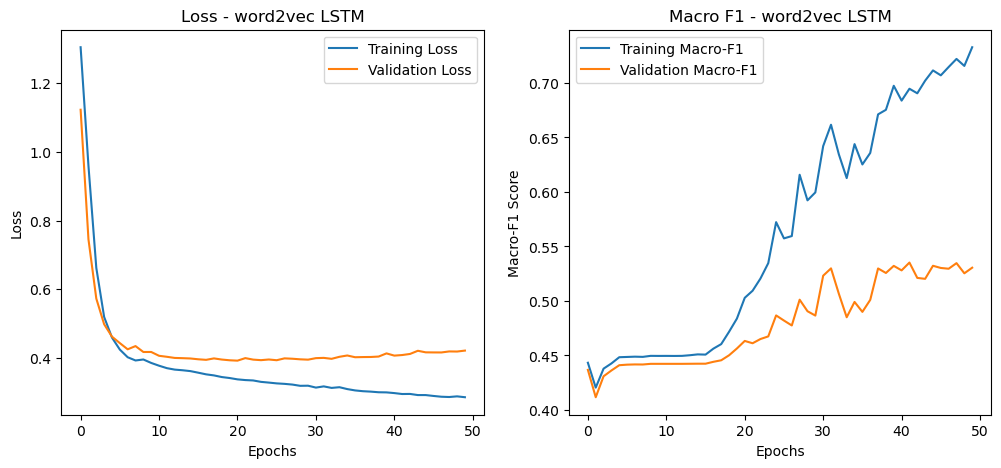

In [201]:
trainLSTM('word2vec')

Epoch 1/50
7/7 [==============================] - 0s 5ms/step
Epoch 1 - Train Macro-F1: 0.4494 - Val Macro-F1: 0.4431
8/8 [==============================] - 2s 107ms/step - loss: 1.2085 - acc: 0.8502 - val_loss: 1.0153 - val_acc: 0.8761
Epoch 2/50
7/7 [==============================] - 0s 5ms/step
Epoch 2 - Train Macro-F1: 0.4393 - Val Macro-F1: 0.4329
8/8 [==============================] - 1s 74ms/step - loss: 0.8742 - acc: 0.8837 - val_loss: 0.6476 - val_acc: 0.8603
Epoch 3/50
7/7 [==============================] - 0s 6ms/step
Epoch 3 - Train Macro-F1: 0.4386 - Val Macro-F1: 0.4322
8/8 [==============================] - 1s 73ms/step - loss: 0.5867 - acc: 0.8592 - val_loss: 0.5534 - val_acc: 0.8592
Epoch 4/50
7/7 [==============================] - 0s 6ms/step
Epoch 4 - Train Macro-F1: 0.4482 - Val Macro-F1: 0.4414
8/8 [==============================] - 1s 73ms/step - loss: 0.4888 - acc: 0.8756 - val_loss: 0.4855 - val_acc: 0.8744
Epoch 5/50
7/7 [==============================] - 0s 6m

/opt/homebrew/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


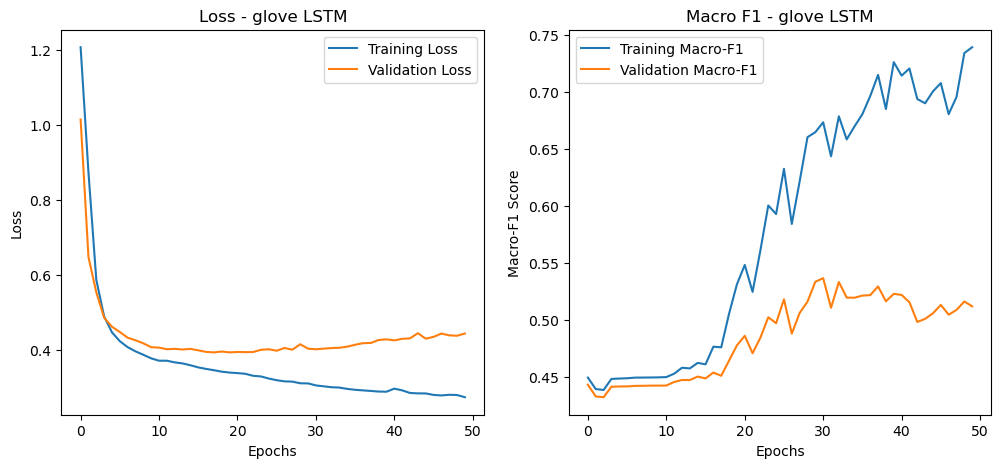

In [202]:
trainLSTM('glove')

Epoch 1/50
7/7 [==============================] - 0s 7ms/step
Epoch 1 - Train Macro-F1: 0.4497 - Val Macro-F1: 0.4425
8/8 [==============================] - 2s 142ms/step - loss: 1.0846 - acc: 0.8779 - val_loss: 0.8456 - val_acc: 0.8763
Epoch 2/50
7/7 [==============================] - 0s 7ms/step
Epoch 2 - Train Macro-F1: 0.4416 - Val Macro-F1: 0.4339
8/8 [==============================] - 1s 108ms/step - loss: 0.6582 - acc: 0.8824 - val_loss: 0.5891 - val_acc: 0.8621
Epoch 3/50
7/7 [==============================] - 0s 8ms/step
Epoch 3 - Train Macro-F1: 0.4487 - Val Macro-F1: 0.4414
8/8 [==============================] - 1s 118ms/step - loss: 0.5033 - acc: 0.8746 - val_loss: 0.5024 - val_acc: 0.8746
Epoch 4/50
7/7 [==============================] - 0s 7ms/step
Epoch 4 - Train Macro-F1: 0.4497 - Val Macro-F1: 0.4425
8/8 [==============================] - 1s 113ms/step - loss: 0.4393 - acc: 0.8859 - val_loss: 0.4583 - val_acc: 0.8763
Epoch 5/50
7/7 [==============================] - 0s

/opt/homebrew/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


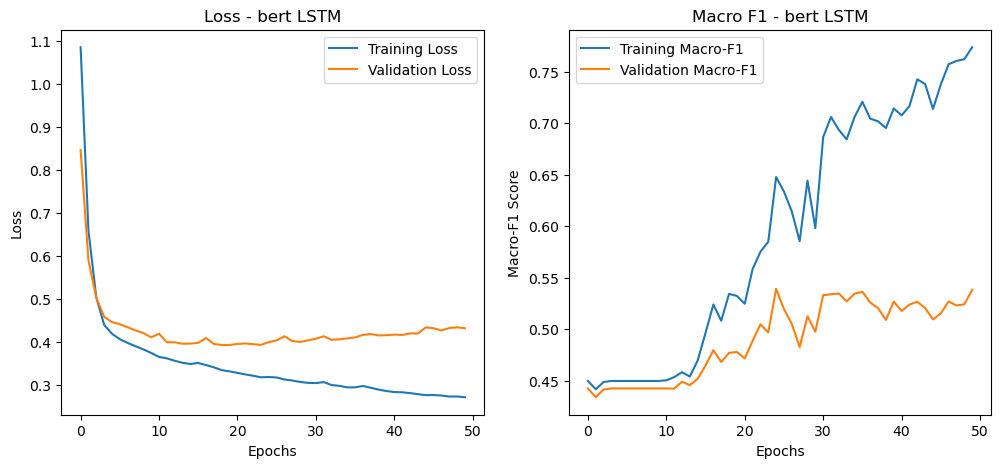

In [203]:
trainLSTM('bert')

## GRU

In [204]:
def trainGRU(embedding):
    X_train, Y_train, X_val, Y_val, embedding_matrix = data[embedding]['X_train'], data[embedding]['Y_train'], data[embedding]['X_val'], data[embedding]['Y_val'], data[embedding]['embedding_matrix']
    
    NUM_CLASSES = data[embedding]['num_classes']
    VOCABULARY_SIZE = data[embedding]['vocab_size']
    EMBEDDING_SIZE = data[embedding]['embedding_dim']
    MAX_SEQUENCE_LENGTH = data[embedding]['max_sequence_length']

    gru_model = Sequential()
    gru_model.add(Embedding(input_dim=VOCABULARY_SIZE,
                            output_dim=EMBEDDING_SIZE,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix],
                            trainable=True))

    gru_model.add(GRU(64, return_sequences=True))

    gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    gru_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    macro_f1_callback = MacroF1ScoreCallback(train_data=(X_train, Y_train), val_data=(X_val, Y_val))

    macro_f1_scores = gru_model.fit(X_train, Y_train, batch_size=128, epochs=50, validation_data=(X_val, Y_val), callbacks=[macro_f1_callback])

    gru_model.save(f'Models/t2_gru_{embedding}.h5')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title(f'Loss - {embedding} GRU')
    plt.plot(macro_f1_scores.history['loss'], label='Training Loss')
    plt.plot(macro_f1_scores.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f'Macro F1 - {embedding} GRU')
    plt.plot(macro_f1_callback.train_f1s, label='Training Macro-F1')
    plt.plot(macro_f1_callback.val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epochs')
    plt.ylabel('Macro-F1 Score')
    plt.legend()

    plt.show()


Epoch 1/50
7/7 [==============================] - 0s 5ms/step
Epoch 1 - Train Macro-F1: 0.4493 - Val Macro-F1: 0.4419
8/8 [==============================] - 1s 97ms/step - loss: 1.2489 - acc: 0.8410 - val_loss: 1.0335 - val_acc: 0.8755
Epoch 2/50
7/7 [==============================] - 0s 5ms/step
Epoch 2 - Train Macro-F1: 0.4451 - Val Macro-F1: 0.4384
8/8 [==============================] - 0s 66ms/step - loss: 0.8624 - acc: 0.8846 - val_loss: 0.6164 - val_acc: 0.8693
Epoch 3/50
7/7 [==============================] - 0s 5ms/step
Epoch 3 - Train Macro-F1: 0.4401 - Val Macro-F1: 0.4328
8/8 [==============================] - 0s 66ms/step - loss: 0.5329 - acc: 0.8722 - val_loss: 0.5574 - val_acc: 0.8605
Epoch 4/50
7/7 [==============================] - 0s 4ms/step
Epoch 4 - Train Macro-F1: 0.4493 - Val Macro-F1: 0.4418
8/8 [==============================] - 0s 66ms/step - loss: 0.4695 - acc: 0.8782 - val_loss: 0.4708 - val_acc: 0.8753
Epoch 5/50
7/7 [==============================] - 0s 5ms

/opt/homebrew/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


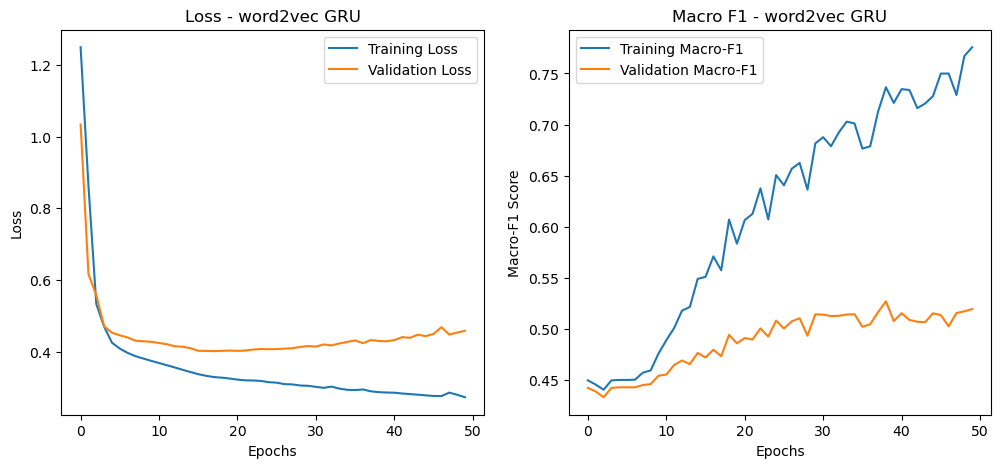

In [205]:
trainGRU('word2vec')

Epoch 1/50
7/7 [==============================] - 0s 5ms/step
Epoch 1 - Train Macro-F1: 0.4495 - Val Macro-F1: 0.4428
8/8 [==============================] - 2s 102ms/step - loss: 1.2672 - acc: 0.7902 - val_loss: 1.0116 - val_acc: 0.8756
Epoch 2/50
7/7 [==============================] - 0s 5ms/step
Epoch 2 - Train Macro-F1: 0.4493 - Val Macro-F1: 0.4420
8/8 [==============================] - 1s 67ms/step - loss: 0.9043 - acc: 0.8857 - val_loss: 0.7236 - val_acc: 0.8756
Epoch 3/50
7/7 [==============================] - 0s 5ms/step
Epoch 3 - Train Macro-F1: 0.4482 - Val Macro-F1: 0.4415
8/8 [==============================] - 1s 67ms/step - loss: 0.5837 - acc: 0.8850 - val_loss: 0.4925 - val_acc: 0.8735
Epoch 4/50
7/7 [==============================] - 0s 5ms/step
Epoch 4 - Train Macro-F1: 0.4497 - Val Macro-F1: 0.4423
8/8 [==============================] - 1s 69ms/step - loss: 0.4585 - acc: 0.8816 - val_loss: 0.5133 - val_acc: 0.8735
Epoch 5/50
7/7 [==============================] - 0s 5m

/opt/homebrew/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


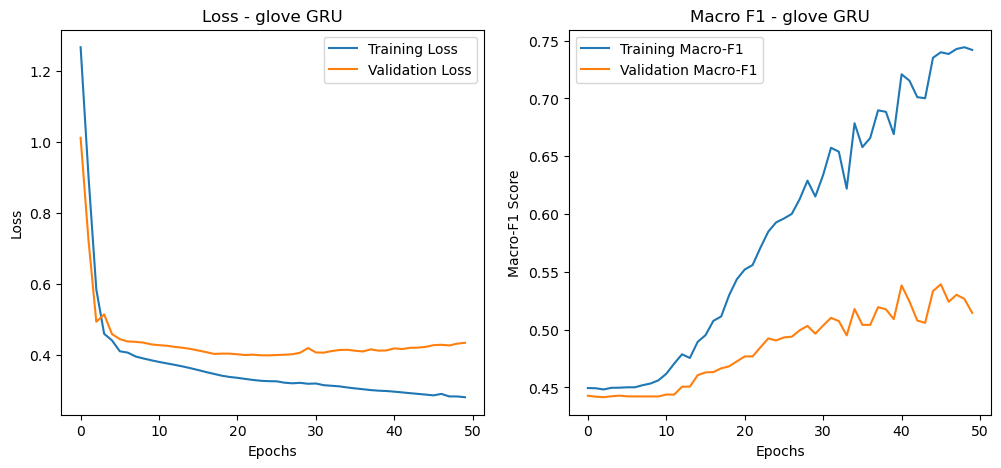

In [206]:
trainGRU('glove')

Epoch 1/50
7/7 [==============================] - 0s 6ms/step
Epoch 1 - Train Macro-F1: 0.4620 - Val Macro-F1: 0.4590
8/8 [==============================] - 2s 124ms/step - loss: 1.1154 - acc: 0.8566 - val_loss: 0.8960 - val_acc: 0.8758
Epoch 2/50
7/7 [==============================] - 0s 7ms/step
Epoch 2 - Train Macro-F1: 0.4497 - Val Macro-F1: 0.4425
8/8 [==============================] - 1s 102ms/step - loss: 0.7317 - acc: 0.8854 - val_loss: 0.5164 - val_acc: 0.8763
Epoch 3/50
7/7 [==============================] - 0s 6ms/step
Epoch 3 - Train Macro-F1: 0.4499 - Val Macro-F1: 0.4424
8/8 [==============================] - 1s 97ms/step - loss: 0.4495 - acc: 0.8864 - val_loss: 0.5049 - val_acc: 0.8762
Epoch 4/50
7/7 [==============================] - 0s 6ms/step
Epoch 4 - Train Macro-F1: 0.4510 - Val Macro-F1: 0.4423
8/8 [==============================] - 1s 96ms/step - loss: 0.4403 - acc: 0.8863 - val_loss: 0.4832 - val_acc: 0.8761
Epoch 5/50
7/7 [==============================] - 0s 6

/opt/homebrew/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


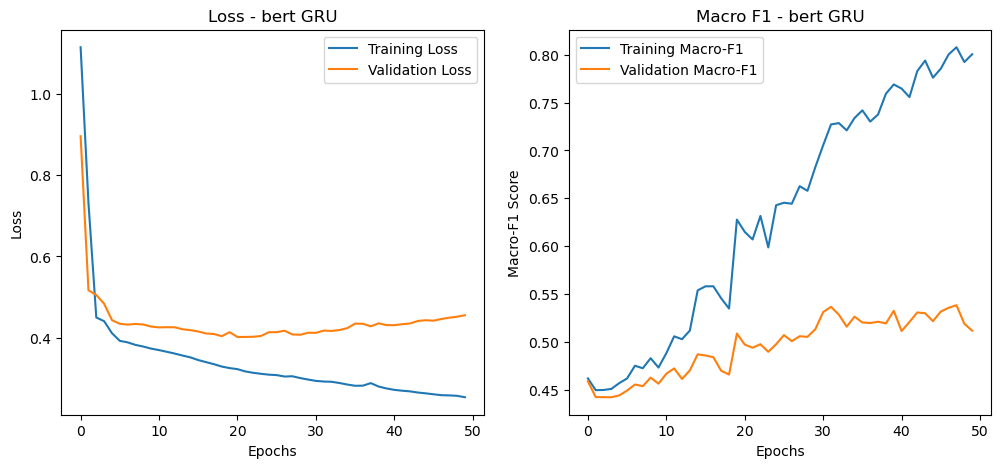

In [207]:
trainGRU('bert')

## EVALUATION

In [208]:
def get_aspect_terms(test_pred, X_test):
    aspect_terms = []
    for i in range(len(test_pred)):
        aspect_term = []
        for j in range(len(test_pred[i])):
            if test_pred[i][j] == 1:
                aspect_term.append(word_tokenizer.index_word[X_test[i][j]])
        aspect_terms.append(aspect_term)
    return aspect_terms

In [209]:
def evaluate_model(model, X_test, Y_test):
    Y_pred = np.argmax(model.predict(X_test), axis=-1)
    Y_true = np.argmax(Y_test, axis=-1)

    aspect_terms = get_aspect_terms(Y_pred, X_test)

    print(f'Macro F1 Score: {f1_score(Y_true.flatten(), Y_pred.flatten(), average="macro"):.4f}')
    print(f'Accuracy: {accuracy_score(Y_true.flatten(), Y_pred.flatten())*100:.2f}%')

    return aspect_terms

In [210]:
rnn_word2vec = load_model('Models/t2_rnn_word2vec.h5')
rnn_glove = load_model('Models/t2_rnn_glove.h5')
rnn_bert = load_model('Models/t2_rnn_bert.h5')

lstm_word2vec = load_model('Models/t2_lstm_word2vec.h5')
lstm_glove = load_model('Models/t2_lstm_glove.h5')
lstm_bert = load_model('Models/t2_lstm_bert.h5')

gru_word2vec = load_model('Models/t2_gru_word2vec.h5')
gru_glove = load_model('Models/t2_gru_glove.h5')
gru_bert = load_model('Models/t2_gru_bert.h5')


print("RNN Word2Vec")
rnn_word2vec_aspect_terms = evaluate_model(rnn_word2vec, data['word2vec']['X_test'], data['word2vec']['Y_test'])

print()
print("RNN Glove")
rnn_glove_aspect_terms = evaluate_model(rnn_glove, data['glove']['X_test'], data['glove']['Y_test'])

print()
print("RNN bert")
rnn_bert_aspect_terms = evaluate_model(rnn_bert, data['bert']['X_test'], data['bert']['Y_test'])

print()
print("LSTM Word2Vec")
lstm_word2vec_aspect_terms = evaluate_model(lstm_word2vec, data['word2vec']['X_test'], data['word2vec']['Y_test'])

print()
print("LSTM Glove")
lstm_glove_aspect_terms = evaluate_model(lstm_glove, data['glove']['X_test'], data['glove']['Y_test'])

print()
print("LSTM bert")
lstm_bert_aspect_terms = evaluate_model(lstm_bert, data['bert']['X_test'], data['bert']['Y_test'])

print()
print("GRU Word2Vec")
gru_word2vec_aspect_terms = evaluate_model(gru_word2vec, data['word2vec']['X_test'], data['word2vec']['Y_test'])

print()
print("GRU Glove")
gru_glove_aspect_terms = evaluate_model(gru_glove, data['glove']['X_test'], data['glove']['Y_test'])

print()
print("GRU bert")
gru_bert_aspect_terms = evaluate_model(gru_bert, data['bert']['X_test'], data['bert']['Y_test'])

RNN Word2Vec
11/11 [==============================] - 0s 2ms/step
Macro F1 Score: 0.5619
Accuracy: 87.90%

RNN Glove
11/11 [==============================] - 0s 2ms/step
Macro F1 Score: 0.5398
Accuracy: 88.46%

RNN bert
11/11 [==============================] - 0s 3ms/step
Macro F1 Score: 0.5424
Accuracy: 88.17%

LSTM Word2Vec
11/11 [==============================] - 0s 5ms/step
Macro F1 Score: 0.5765
Accuracy: 88.82%

LSTM Glove
11/11 [==============================] - 0s 5ms/step
Macro F1 Score: 0.5484
Accuracy: 89.05%

LSTM bert
11/11 [==============================] - 0s 6ms/step
Macro F1 Score: 0.5715
Accuracy: 88.68%

GRU Word2Vec
11/11 [==============================] - 0s 4ms/step
Macro F1 Score: 0.5513
Accuracy: 88.24%

GRU Glove
11/11 [==============================] - 0s 4ms/step
Macro F1 Score: 0.5462
Accuracy: 89.05%

GRU bert
11/11 [==============================] - 0s 5ms/step
Macro F1 Score: 0.5289
Accuracy: 89.06%
